# Convolutional Neural Networks

**Prerequisites**

- Tensorflow + keras
- SGD
- MLP

**Outcomes**

- Understand the core concepts behind the Convolutional Neural network
- Understand the math behind `keras.layers.Conv2d` and `keras.layers.MaxPooling2D`
- Be able to define and fit a CNN using keras

In [1]:
import tensorflow
from tensorflow import keras
import matplotlib.pyplot as plt
import plotly.express as px

## Reminder: Neural Networks as Function Composition

- Recall the function composition form of the multilayer perceptron model: $$y = (f_{\text{out}} \circ D_L \circ f_{L-1} \circ D_{L-1} \circ \cdots \underbrace{f_1 \circ D_1}_{\text{key pattern}})(x)$$
- Each function $D_l(x) = W x + b$ are called `Dense` layers and $f_l$ are activation functions
- This same structure (composing one function after another) is common for all feed forward or sequential deep neural networks
- Today we will learn about another type of neural network: convolutional neural networks (CNN)
    - The `Dense` layers will be replaced by `Conv2d` plus pooling layers

### Motivation: Image classification

- The CNN architecture gained popularity for its use in image classification problems
- Why? Consider MLP for images
    - MLP connects all layer inputs to all layer outputs
    - For image, all pixels to all neurons
    - No spatial awareness
- CNN, on the other hand: 
    - connects local block of layer inputs to each output
    - Can identify localized patterns like shapes within an image

### Example Image

- Consider an image

In [2]:
from sklearn import datasets

china = datasets.load_sample_image('china.jpg')
px.imshow(china)

- In python this is represented as a 3 dimensional array:

In [3]:
china[:2, :2, :]

array([[[174, 201, 231],
        [174, 201, 231]],

       [[172, 199, 229],
        [173, 200, 230]]], dtype=uint8)

In [4]:
china.shape

(427, 640, 3)

- Dimensions are height, width, depth
- Here we have 3 depth dimensions for the 3 color channels red, blue, and green

### Local patterns in image

- Consider 4 rectangular shapes from the image
- Each has same subset of pixels in first dimension (`196:220`)
- Each has same width in second dimension (5 pixels)

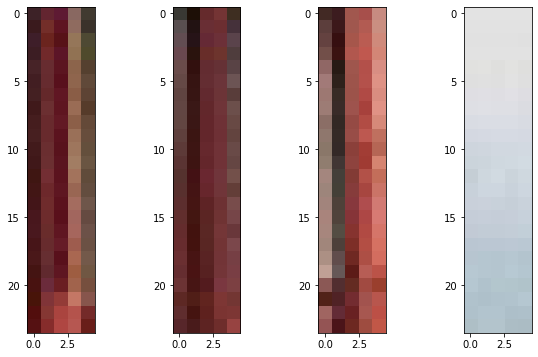

In [5]:
fig, ax = plt.subplots(1, 4, figsize=(10, 6))

ax[0].imshow(china[196:220, 208:213, :])
ax[1].imshow(china[196:220, 252:257, :])
ax[2].imshow(china[196:220, 278:283, :])
ax[3].imshow(china[196:220, 360:365, :])

- Three of these are similar (first 3)
- Fourth one is very different
- Wouldn't it be nice if...
    - Our neural network were able to identify patterns that lead to similar activations for sub-images 1-3, but not for 4
    - CNNs can...

## CNN Theory

- A typical convolutional neural network might look as follows: $$y = (f_{\text{out}} \circ D_{\text{out}} \circ P_L \circ \cdots \circ P_6 \circ f_5 \circ C_{5} \circ f_4 \circ C_4 \underbrace{\circ P_3 \circ f_2 \circ C_{2} \circ f_1 \circ C_1}_{\text{key pattern}})(x)$$
- $C_l$ represents a convolutional layer
- $P_l$ represents a pooling layer
- As with MLP, we will look at the key layers of the CNN from three perspectives:
    - Visual
    - Mathematical
    - Code

### Overview

- The convolutional layer works as follows:
    - Layer inputs are processed locally
    - Each local region (rectangle) is convolved with coefficient vector (filter or kernel) to produce a single output (convolved = dot proudct)
    - We then "slide" the local region of the input to compute the next output
    - The full output is called a feature map
    - We can choose how many filters or feature maps appear in each conv layer

### Visual Perspective: A convolutional layer

- The image below shows core features from a visual perspective

![cnn_neuron.png](cnn_neuron.png)

(Source: [Stanford cs231n](https://cs231n.github.io/convolutional-networks/))

#### Visual Perspective: CNN

- Many of these convolution layers can be stacked into a convolutional neural network
- This might look as follows:

![cnn_visual.png](cnn_visual.png)

(Source: [KDNuggets](https://www.kdnuggets.com/2016/11/intuitive-explanation-convolutional-neural-networks.html/3))

#### Example: "specialized filters"

- Below are some common convolutional filters (kernels) used in image processing
- This is *not* something your CNN would likely learn, but shows you the type of processing that can be done by a convolution

![cnn_filter_examples.png](cnn_filter_examples.png)

(Source: [Wikipedia](https://en.wikipedia.org/wiki/Kernel_(image_processing)))

### Mathematical Perspective: Feature Map

- Personally, the equations for convolutional layers are less intuitive/enlightening than the equations for the MLP
- A treatment of the math requires non-trivial notation
- We'll opt to not present it, but rather talk through how it works given the animation below:

![cnn_ops.gif](cnn_ops.gif)

(Source: [Medium](https://towardsdatascience.com/lets-code-convolutional-neural-network-in-plain-numpy-ce48e732f5d5))

#### Mathematical Perspective: Conv layer

- The previous animation showed operations for a single feature map
- In a Conv layer, there are many stacked together depth-wise
- Each feature map has its own kernel and bias

![cnn_math.png](cnn_math.png)

#### Hyperparameters

- For each conv layer, we need to pick a few hyper parameters
    - Number of filters $K$: how many items in output dimension
    - their spatial extent $F$: How wide/tall filters are
    - the stride $S$: how far to "skip" each time we slide filter
    - the amount of zero padding $P$: chosen to make dimensions "line up"
- In practice you must set $K$ and $F$, sometimes $S$, almost never $P$

#### Max Pooling

- After one or more Conv+activation layers, CNNs often have a pooling layer
- The mathematical operation is relatively simple:
    - For each subregion of layer inputs, set the output equal to the maximum value


#### Why Pooling?

- Resource efficiency:
    - Images come in w x h x 3
    - Conv layer output is w1 x h1 x k1 -- where k1 often 32 or 64
    - 2x2 max pooling cuts down number of items in tensor by factor of 4
- De-noising
    - Having very wide/tall feature maps carries abundant information
    - In practice, might be excessive
    - Pooling forces network to focus on most active/most relevant features 
    - Can improve performance

#### Summary

- Putting it all together we have a CNN similar to the following:

![cnn_layers.png](cnn_layers.png)

### Code Perspective

- Pause... breath... that was a lot!
- The CNN has more new theory to learn, but isn't any harder to use
- Keras has layers that we can add to a `Sequential` model to create a CNN

> Note: another instance of knowing the details isn't necessary to build/use a CNN, but is extremely helpful to practice effectively + diagnose problems + understand/interpret outputs

#### Our First CNN

- Let's build our first CNN in keras
- We'll apply it to the fashion MNIST image classification problem we saw before

> Recall the validation accuracy we achieved using an MLP wa about 86%...

Number of original training examples: 60000
Number of original test examples: 10000
Shape of x_train: (60000, 28, 28, 1)


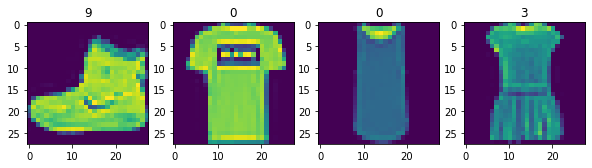

In [6]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()


# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., None]/255.0, x_test[...,None]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))
print("Shape of x_train:", x_train.shape)

fig, ax = plt.subplots(1, 4, figsize=(10, 6))
for i in range(4):
    ax[i].imshow(x_train[i, :, :, :])
    ax[i].set_title(y_train[i])

In [7]:
cnn = keras.Sequential([
    # Part 1: first (Conv)+ => Pool stack
    # Conv layer with 32 filters of size 3x3
    keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=x_train.shape[1:]),
    keras.layers.Conv2D(32, (3, 3), activation="relu"),
    keras.layers.MaxPool2D((2, 2)),
    
    # Part 2: second (Conv)+ => Pool stack
    keras.layers.Conv2D(32, (3, 3), activation="relu"),
    keras.layers.Conv2D(32, (3, 3), activation="relu"),
    keras.layers.MaxPool2D((2, 2)),
    
    # Part 3: Flatten
    keras.layers.Flatten(),
    
    # Part 4: Classifier
    keras.layers.Dense(200, activation="relu"),
    
    # Part 5: output layer
    keras.layers.Dense(len(set(y_train)), activation="softmax")
])

cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 32)          9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 32)         0         
 2D)                                                    

In [8]:
cnn.compile(optimizer='rmsprop',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])
hist = cnn.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=30)

Epoch 1/30
1875/1875 [==============================] - 260s 138ms/step - loss: 0.4633 - accuracy: 0.8281 - val_loss: 0.3527 - val_accuracy: 0.8738
Epoch 2/30
1875/1875 [==============================] - 201s 107ms/step - loss: 0.2983 - accuracy: 0.8918 - val_loss: 0.2904 - val_accuracy: 0.9001
Epoch 3/30
1875/1875 [==============================] - 204s 109ms/step - loss: 0.2557 - accuracy: 0.9070 - val_loss: 0.3219 - val_accuracy: 0.8961
Epoch 4/30
1875/1875 [==============================] - 198s 106ms/step - loss: 0.2336 - accuracy: 0.9160 - val_loss: 0.2656 - val_accuracy: 0.9080
Epoch 5/30
1875/1875 [==============================] - 279s 149ms/step - loss: 0.2233 - accuracy: 0.9204 - val_loss: 0.3070 - val_accuracy: 0.9094
Epoch 6/30
1875/1875 [==============================] - 223s 119ms/step - loss: 0.2167 - accuracy: 0.9234 - val_loss: 0.2872 - val_accuracy: 0.8948
Epoch 7/30
1875/1875 [==============================] - 139s 74ms/step - loss: 0.2111 - accuracy: 0.9259 - val_l

### Modern CNNs

- The architecture we described was proposed by Turing award winner Yann LeCun in the late 1990s (called "LeNet")
- Deep learning had little progress for the subsequent ~15 years, but exploded in the 2010s
- Now off the shelf CNN models can achieve super (or near) human performance on a variety of image processing tasks
- Keras has many of these models built-in
- In the future we'll leverage the built-in models (and transfer learning!) when using CNNs for image tasks